# Setup

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.char_tokenizer import CharTokenizer

In [3]:
tf.config.experimental.get_memory_info("GPU:0")

2023-05-23 08:29:12.003754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 08:29:12.672869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30976 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0


{'current': 0, 'peak': 0}

In [4]:
config = json.load(open("config.json"))

# Loading data

In [5]:
data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)
data['product_type'] = data['product_type.value']
data = data[['description', 'path', 'product_type', 'label']]
data

,description,path,product_type,label
0,desk small desk white desk desks computer desk...,cc/cc3664a2.jpg,DESK,1
1,mobile coverb07tg4lwrdamazon brand - solimo de...,4c/4c015ec6.jpg,CELLULAR_PHONE_CASE,1
2,cellphonecoverb0856b3szqamazon brand - solimo ...,b9/b983774d.jpg,CELLULAR_PHONE_CASE,1
3,wirebindb07yb3c3qbamazonbasics coil binding sp...,35/3595924e.jpg,OFFICE_PRODUCTS,1
4,mobile coverb07vsn27mtcare of by puma men's me...,66/66f9dc3f.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
157196,spray mopb07n13rptwamazon brand - solimo desig...,f2/f22aceeb.jpg,CELLULAR_PHONE_CASE,0
157197,mobile coverb07tf1fnrjamazon brand - solimo de...,2f/2fbbde2c.jpg,CELLULAR_PHONE_CASE,1
157198,back coverb0854fk2xramazon brand - solimo desi...,a6/a6ab33b4.jpg,CELLULAR_PHONE_CASE,1
157199,mobile coverb07tg4j5g5amazon brand - solimo de...,5f/5ff1525e.jpg,CELLULAR_PHONE_CASE,1


In [6]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [7]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(157201, 1014)

## Create embedding weights

In [8]:
weights = tk.create_embedding_weights()
weights.shape

(3188, 3187)

# Image processing

## Load image model

In [9]:
from utils import img_models

In [10]:
img_model = img_models.load(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [ ]:
img = img_models.create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"))

In [ ]:
img.shape

# Save embeddings

In [11]:
save_path = os.path.join(config["data"]["path"], "embeddings")

In [ ]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [12]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,desk small desk white desk desks computer desk...,cc/cc3664a2.jpg,DESK,1
1,mobile coverb07tg4lwrdamazon brand - solimo de...,4c/4c015ec6.jpg,CELLULAR_PHONE_CASE,1
2,cellphonecoverb0856b3szqamazon brand - solimo ...,b9/b983774d.jpg,CELLULAR_PHONE_CASE,1
3,wirebindb07yb3c3qbamazonbasics coil binding sp...,35/3595924e.jpg,OFFICE_PRODUCTS,1
4,mobile coverb07vsn27mtcare of by puma men's me...,66/66f9dc3f.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
157196,spray mopb07n13rptwamazon brand - solimo desig...,f2/f22aceeb.jpg,CELLULAR_PHONE_CASE,0
157197,mobile coverb07tf1fnrjamazon brand - solimo de...,2f/2fbbde2c.jpg,CELLULAR_PHONE_CASE,1
157198,back coverb0854fk2xramazon brand - solimo desi...,a6/a6ab33b4.jpg,CELLULAR_PHONE_CASE,1
157199,mobile coverb07tg4j5g5amazon brand - solimo de...,5f/5ff1525e.jpg,CELLULAR_PHONE_CASE,1


In [13]:
img = np.load(f"{save_path}/img.npy")
img.shape

(157201, 576)

In [14]:
text = np.load(f"{save_path}/text.npy")
text.shape

(157201, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [15]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > 1]

In [16]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=0.1, random_state=42)

In [19]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [20]:
from models.char_cnn_zhang import CharCNNZhang

In [21]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fully_connected_layers": config["char_cnn_zhang"]["fully_connected_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [22]:
# txt_model = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

In [23]:
from models.mnn_em import MNNEM
from utils.eval import create_metrics

In [24]:
mnn_em = MNNEM(img_input_size=img_model.layers[-1].output_shape[1],
              img_conv_layers=config["mnn_em"]["img_conv_layers"],
              txt_input_size=config["data"]["input_size"],
              txt_conv_layers=config["mnn_em"]["txt_conv_layers"],
              txt_weights=weights,
              char_cnn_config=char_cnn_config,
              combined_conv_layers=config["mnn_em"]["combined_conv_layers"],
              learning_rate=config["mnn_em"]["training"]["learning_rate"],
              metrics=create_metrics(config["mnn_em"]["training"]["metrics"]))

In [25]:
mnn_em.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Character_Level_CNN (Functiona  (None, 2048)        29180700    ['Text_Input[0][0]']             
 l)                                                                                               
                                                                                                  
 Image_FC_1 (Dense)             (None, 1024)         590848      ['Image_Input[0][0]']        

In [26]:
tf.keras.utils.plot_model(mnn_em.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [27]:
from utils.eval import create_callbacks

In [28]:
model_name = config["mnn_em"]["name"]
optimizer_name = config["mnn_em"]["training"]["optimizer"]
learning_rate = config["mnn_em"]["training"]["learning_rate"]

In [29]:
callbacks = create_callbacks(
    callbacks_list=config["mnn_em"]["training"]["callbacks"],
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    )

# Training

In [29]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["mnn_em"]["training"]["epochs"],
    validation_split=config["mnn_em"]["training"]["validation_split"],
    batch_size=config["mnn_em"]["training"]["batch_size"], 
callbacks=callbacks)


Epoch 1/10


2023-05-23 05:54:25.373565: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8901


7956/7956 [==============================] - ETA: 0s - loss: 0.9782 - recall: 0.9442 - precision: 0.8829 - binary_accuracy: 0.8992 - cosine_similarity: 0.5569

2023-05-23 06:03:09.024408: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 528s 66ms/step - loss: 0.9782 - recall: 0.9442 - precision: 0.8829 - binary_accuracy: 0.8992 - cosine_similarity: 0.5569 - val_loss: 0.2024 - val_recall: 0.9858 - val_precision: 0.9240 - val_binary_accuracy: 0.9473 - val_cosine_similarity: 0.5532
Epoch 2/10
7955/7956 [============================>.] - ETA: 0s - loss: 0.1861 - recall: 0.9767 - precision: 0.9366 - binary_accuracy: 0.9502 - cosine_similarity: 0.5569

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 534s 67ms/step - loss: 0.1861 - recall: 0.9767 - precision: 0.9366 - binary_accuracy: 0.9502 - cosine_similarity: 0.5569 - val_loss: 0.1704 - val_recall: 0.9744 - val_precision: 0.9497 - val_binary_accuracy: 0.9573 - val_cosine_similarity: 0.5532
Epoch 3/10
7956/7956 [==============================] - 531s 67ms/step - loss: 0.1566 - recall: 0.9804 - precision: 0.9464 - binary_accuracy: 0.9582 - cosine_similarity: 0.5569 - val_loss: 0.1754 - val_recall: 0.9761 - val_precision: 0.9426 - val_binary_accuracy: 0.9539 - val_cosine_similarity: 0.5532
Epoch 4/10
7955/7956 [============================>.] - ETA: 0s - loss: 0.1326 - recall: 0.9831 - precision: 0.9552 - binary_accuracy: 0.9649 - cosine_similarity: 0.5569

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 537s 67ms/step - loss: 0.1326 - recall: 0.9831 - precision: 0.9552 - binary_accuracy: 0.9649 - cosine_similarity: 0.5569 - val_loss: 0.1423 - val_recall: 0.9866 - val_precision: 0.9496 - val_binary_accuracy: 0.9636 - val_cosine_similarity: 0.5532
Epoch 5/10
7956/7956 [==============================] - 530s 67ms/step - loss: 0.1176 - recall: 0.9854 - precision: 0.9610 - binary_accuracy: 0.9696 - cosine_similarity: 0.5569 - val_loss: 0.1613 - val_recall: 0.9498 - val_precision: 0.9617 - val_binary_accuracy: 0.9513 - val_cosine_similarity: 0.5532
Epoch 6/10
7956/7956 [==============================] - 528s 66ms/step - loss: 0.1034 - recall: 0.9867 - precision: 0.9664 - binary_accuracy: 0.9734 - cosine_similarity: 0.5569 - val_loss: 0.1525 - val_recall: 0.9771 - val_precision: 0.9510 - val_binary_accuracy: 0.9595 - val_cosine_similarity: 0.5532
Epoch 7/10
7956/7956 [==============================] - 529s 67ms/step - loss: 0.0902 - recall: 0.9880

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/MobilenetV3small/Adam/lr_0.0001/assets


7956/7956 [==============================] - 536s 67ms/step - loss: 0.0644 - recall: 0.9913 - precision: 0.9815 - binary_accuracy: 0.9848 - cosine_similarity: 0.5569 - val_loss: 0.1162 - val_recall: 0.9819 - val_precision: 0.9639 - val_binary_accuracy: 0.9696 - val_cosine_similarity: 0.5532


# Evaluation

## Plot loss and metrics

In [31]:
from utils.eval import plot_metrics

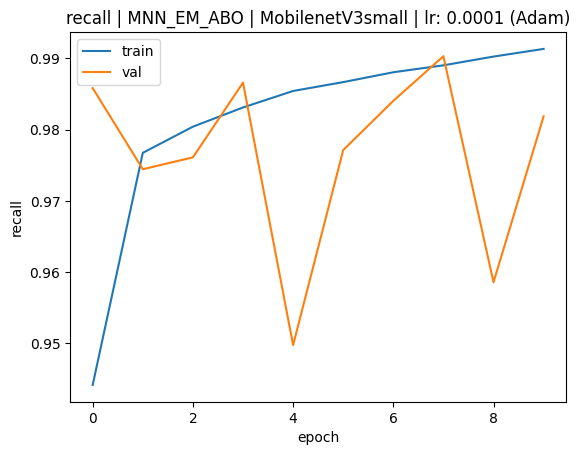

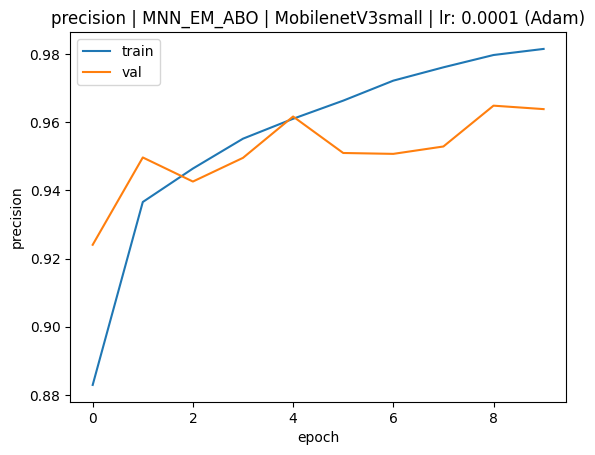

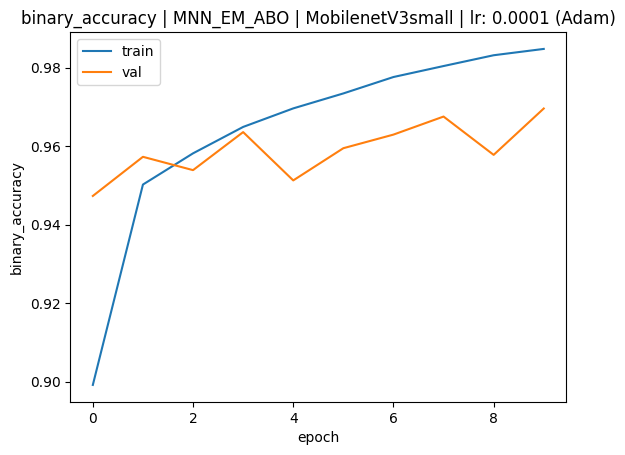

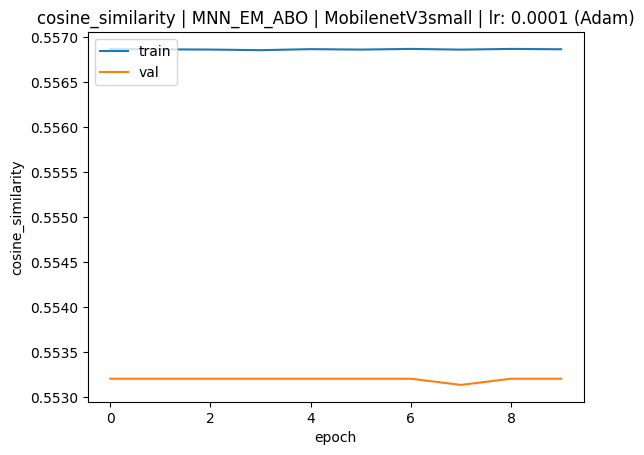

In [56]:
plot_metrics(history.history, config["mnn_em"]["training"]["metrics"], model_name, img_model.name, optimizer_name, learning_rate)

## Save metrics

In [31]:
from utils.eval import evaluate

In [32]:
evaluate(mnn_em.model, img_test, text_test, labels_test, model_name, img_model.name, optimizer_name, learning_rate)

2023-05-23 08:29:28.827143: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8901


15714/15714 [==============================] - 62s 4ms/step - loss: 0.1156 - recall: 0.9835 - precision: 0.9640 - binary_accuracy: 0.9707 - cosine_similarity: 0.5514
